# 正弦信号发生


## 查表法构建正弦信号
事先存储好需要计算的正弦函数值，然后通过保持的方式输出，则得到离散的波形，最后使用低通滤波，使曲线更加光滑。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


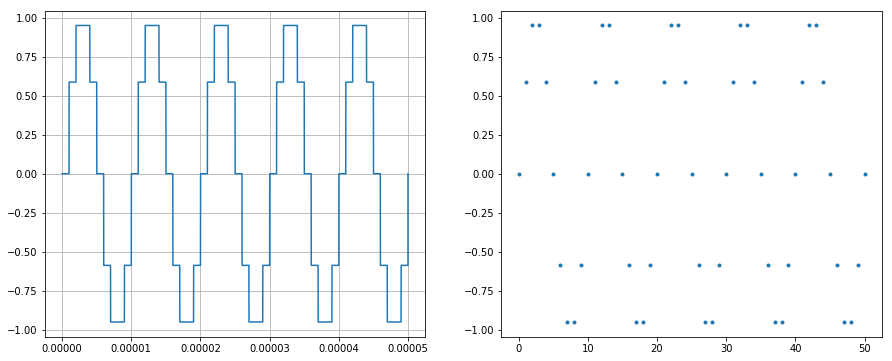

In [2]:
# 查表法生成正弦信号函数
def signal_sin(A, f, n, dt) :
    # A表示幅值，f表示频率，n表示需要填充的点数，dt表示仿真时的离散时间最小单位
    T = 1/f
    t = np.arange(0, 5*T + 2*dt, dt)    # 仿真10个周期时间
    
    
    delta_t = T/n                   # 表示信号的保持时间
    delta_n = delta_t / dt          # 信号保持的仿真间隔   
    signal = []                     # 初始化信号
    signal2 = []
    data = math.sin(2*math.pi*0/T)  # 初始填充值
    count = 0
    signal2.append(data)
    for i in t :
        if i >= (count + 1)*delta_t : # 判断是否到下一个时间平台
            count = (count + 1)
            data = math.sin(2*math.pi*(count%n)*delta_t/T) # 更改填充数值，直接调用系统函数，相当于查表
            signal2.append(data)
        signal.append(data)
        
    np_signal = np.array(signal)
    np_signal2 = np.array(signal2)
    return [t, np_signal, signal2]

# 测试
[t, sin_signal, signal2] = signal_sin(1, 100000, 10, 1e-9)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
ax1.plot(t, sin_signal)
ax1.grid()
ax2.plot(signal2,'.')


# CORDIC法生成正弦信号
CORDIC法是一种迭代法计算正弦信号的方法。这种方法将计算三角函数这种非线性函数，巧妙运用坐标变换的性质设计了一种迭代计算的方法，使得三角函数可以通过迭代的方式计算，并且可以很方便的控制精度。
## 基本原理
坐标变换的公式为：               
$$                          
\begin{equation}
x' = x \cdot cos\theta - y \cdot sin\theta \\
y' = x \cdot sin\theta + y \cdot cos\theta
\end{equation}
$$
其本质是矩阵的线性变换
$$
\begin{equation}
\left[\begin{matrix}x'\\y'\end{matrix}\right]
= \left[ \begin{matrix}
cos\theta & -sin\theta\\
sin\theta & cos\theta
\end{matrix} \right]
\left[\begin{matrix} x\\y \end{matrix}\right]
\end{equation}
$$
通过三角函数的万能公式，可以进一步使其化简：
\begin{equation}
con\theta = \frac{tan\theta}{\sqrt{1 + tan\theta^2}} \\
sin\theta = \frac{1}{\sqrt{1 + tan\theta^2}}
\end{equation}
带入之后，构成迭代公式则可以组成只有乘法和加法的迭代运算。

首先需要得到需要存储的数值

In [3]:
a = np.array([2**(-i) for i in range(11)])
phi = np.arctan(a) / math.pi * 180
# print(phi)

phi = np.round(phi,2)
k = np.cos(np.arctan(a))
print(phi)
print(k)

[ 45.    26.57  14.04   7.13   3.58   1.79   0.9    0.45   0.22   0.11
   0.06]
[ 0.70710678  0.89442719  0.9701425   0.99227788  0.99805258  0.99951208
  0.99987795  0.99996948  0.99999237  0.99999809  0.99999952]


In [4]:
# CORDIC正弦函数运算方法
def cordic_sin(theta, error, debug=0) :
    # 先处理数据，只能计算0～90的
    tmp = round(theta / 360 - 0.5) 
    
    theta = theta - tmp * 360
    sign = 1
    if theta > 90 and theta <= 180 :
        theta = abs(theta - 180)
        sign = 1
    elif theta > 180 and theta <= 270 :
        theta = theta - 180
        sign = -1
    elif theta > 270 and theta <= 360 :
        theta = abs(theta - 360)
        sign = -1
        
    x = 1
    y = 0
    theta_real = 0
    index = 0
    d = 1
    if debug :
        print('%d %lf %d %lf %lf'%(index, theta_real,d,x,y))
    while True:
        if index == 11 :
            break
        if abs(theta_real-theta) <= error * theta :
            break  # 达到误差就跳出
        if theta_real < theta : # 决定该次的符号
            d = 1
        else :
            d = -1
         
        # 执行迭代步骤
        tmpx = x
        tmpy = y
        x = (tmpx - tmpy*d*2**(-index))*k[index]
        y = (tmpy + tmpx*d*2**(-index))*k[index]
        theta_real = theta_real + d*phi[index]
        index = index + 1
        if debug :
            print('%d %lf %d %lf %lf'%(index, theta_real,d,x,y))
    return sign * y
th = 500
print('result = %lf, real = %lf'%(cordic_sin(th, 0.001),math.sin(th/180*math.pi)))

result = 0.643320, real = 0.642788


使用cordic方法产生正弦信号

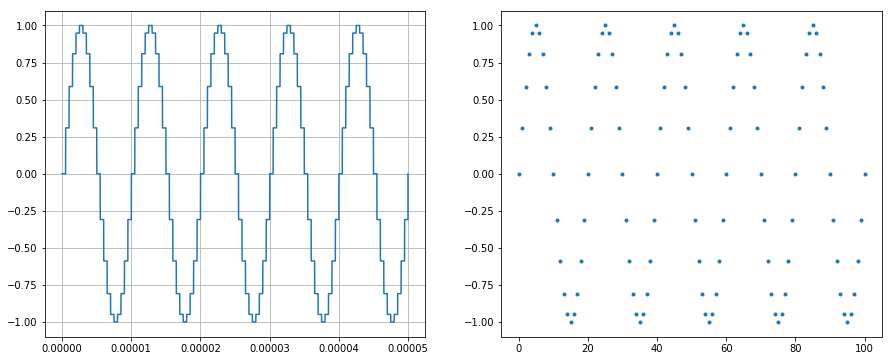

In [5]:
# 查表法生成正弦信号函数
def signal_sin_cordic(A, f, n, dt) :
    # A表示幅值，f表示频率，n表示需要填充的点数，dt表示仿真时的离散时间最小单位
    T = 1/f
    t = np.arange(0, 5*T + 2*dt, dt)    # 仿真10个周期时间
    
    
    delta_t = T/n                   # 表示信号的保持时间
    delta_n = delta_t / dt          # 信号保持的仿真间隔   
    signal = []                     # 初始化信号
    signal2 = []
    data = cordic_sin(0,0.01)  # 初始填充值
    count = 0
    signal2.append(data)
    for i in t :
        if i >= (count + 1)*delta_t : # 判断是否到下一个时间平台
            count = (count + 1)
            tmp_theta = 360*(count%n)*delta_t/T
            data = cordic_sin(tmp_theta, 0.01) # 更改填充数值，直接调用系统函数，相当于查表
            signal2.append(data)
        signal.append(data)
        
    np_signal = np.array(signal)
    np_signal2 = np.array(signal2)
    return [t, np_signal, signal2]

# 测试
[t, sin_signal, signal2] = signal_sin_cordic(1, 100000, 20, 1e-9)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
ax1.plot(t, sin_signal)
ax1.grid()
ax2.plot(signal2,'.')


对上述两算法进行比较

In [6]:
%%time
[t, sin_signal, signal2] = signal_sin(1, 100000, 1000, 1e-9)

CPU times: user 24.5 ms, sys: 2.7 ms, total: 27.2 ms
Wall time: 29.8 ms


In [7]:
%%time
[t, sin_signal, signal2] = signal_sin_cordic(1, 100000, 1000, 1e-9)

CPU times: user 103 ms, sys: 4.1 ms, total: 107 ms
Wall time: 114 ms


可以发现，还是查表算法相对快一些，但是只需要优化，这种cordic算法的性能是十分可观的，而且占用存储空间极小。

## 作业1
产生频率为100kHz的信号，并分别使用10，20，40，100，400，800，2000个点并给予FFT显示

In [8]:
#构建一个测试函数, 查表法的测试
def test_func(n) :
    # 查表法
    [t, sin_signal, signal2] = signal_sin(1, 100000, n, 1e-9)
    fft_signal = np.fft.fft(signal2)/len(signal2)

    freq = np.arange(-1,1,2/len(signal2))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
    ax1.plot(signal2,'.')
    ax1.set_title('sin signal n = %d'%n)
    ax1.set_xlabel('time')
    # ax1.title(siginal)
    ax2.stem(freq[0:len(fft_signal)], abs(fft_signal))
    ax2.set_title('signal fft')
    ax2.set_xlabel(r'w')

### 查表法测试

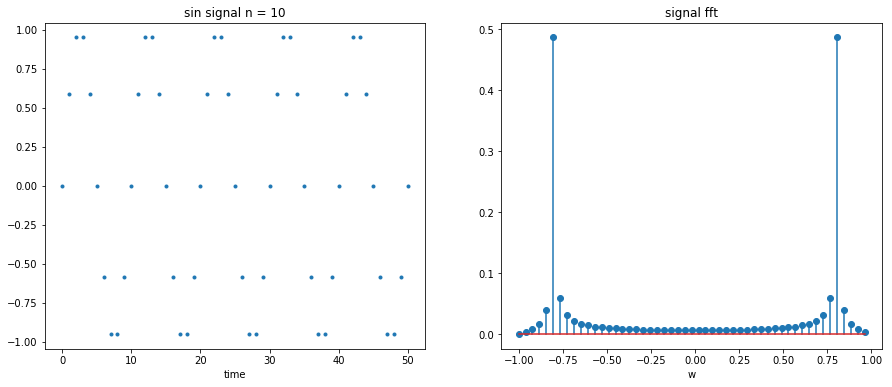

In [9]:
test_func(10)

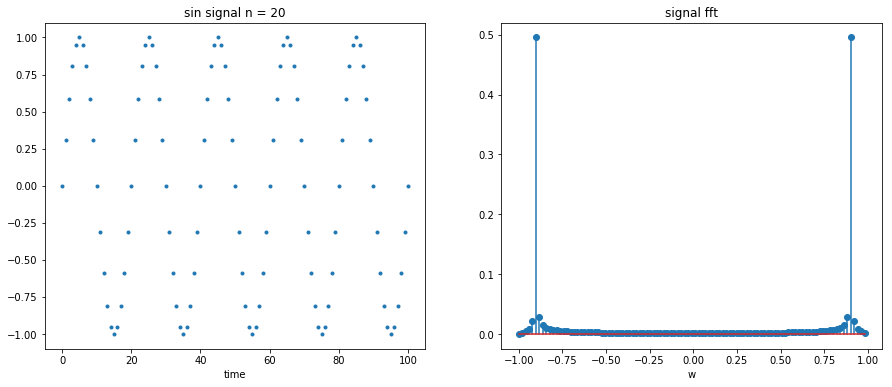

In [10]:
test_func(20)

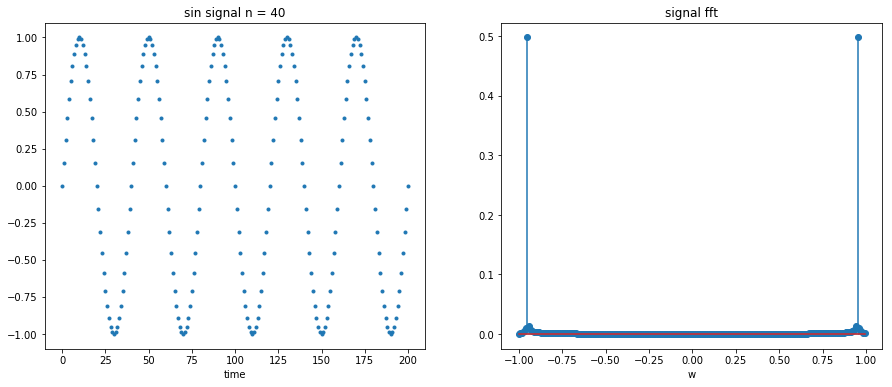

In [11]:
test_func(40)

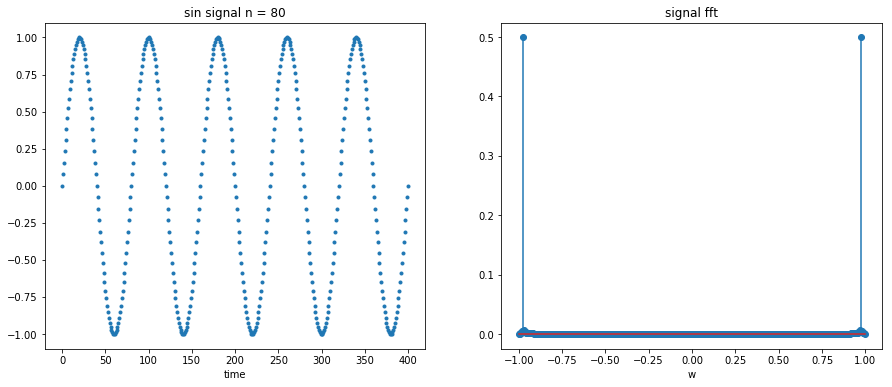

In [12]:
test_func(80)

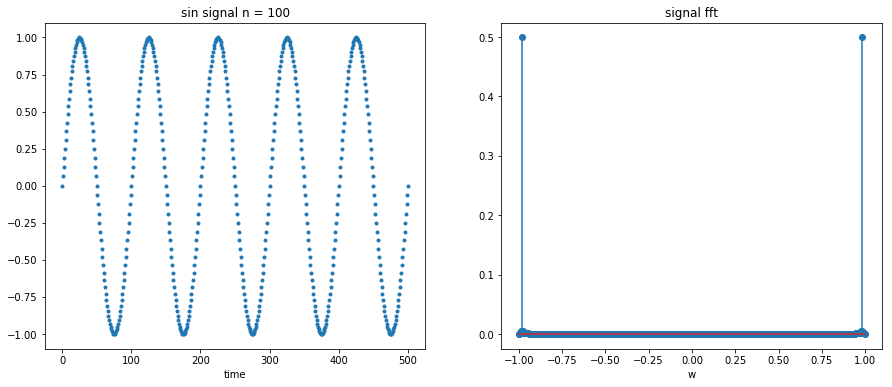

In [13]:
test_func(100)

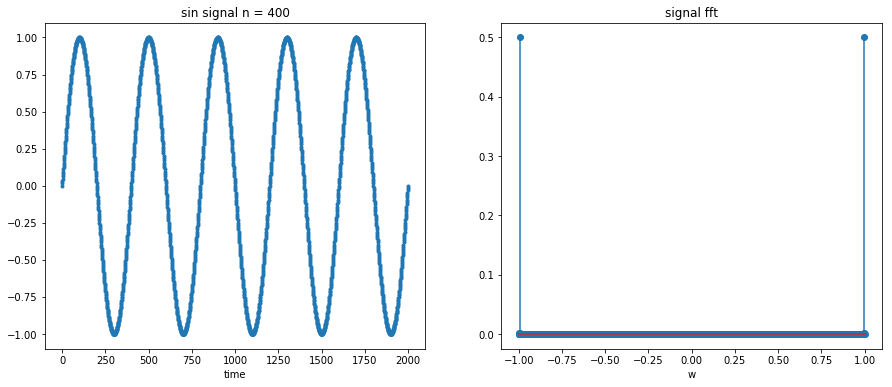

In [14]:
test_func(400)

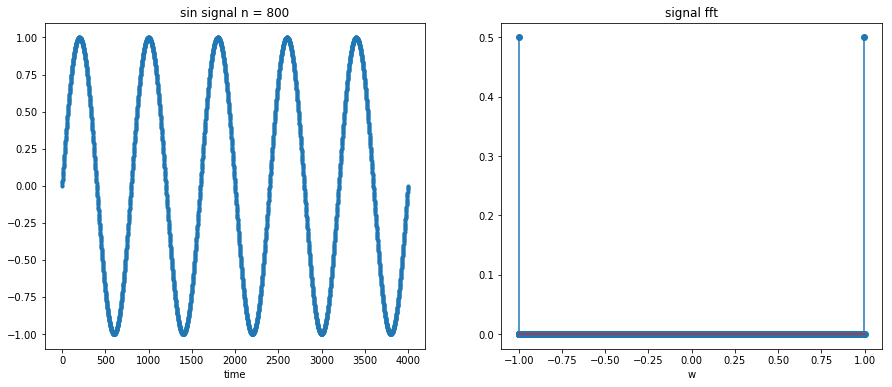

In [15]:
test_func(800)

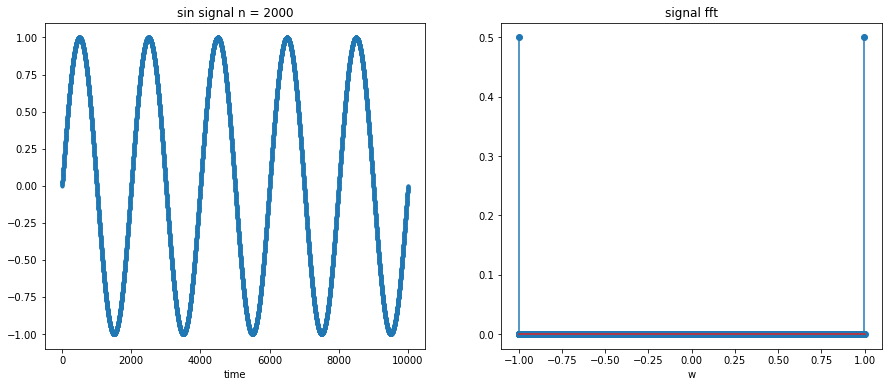

In [16]:
test_func(2000)

In [17]:
#构建一个测试函数, cordic法的测试
def test_func2(n) :
    # 查表法
    [t, sin_signal, signal2] = signal_sin_cordic(1, 100000, n, 1e-9)
    fft_signal = np.fft.fft(signal2)/len(signal2)

    freq = np.arange(-1,1,2/len(signal2))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
    ax1.plot(signal2,'.')
    ax1.set_title('sin signal n = %d'%n)
    ax1.set_xlabel('time')
    # ax1.title(siginal)
    ax2.stem(freq[0:len(fft_signal)], abs(fft_signal))
    ax2.set_title('signal fft')
    ax2.set_xlabel(r'w')

### cordic法测试

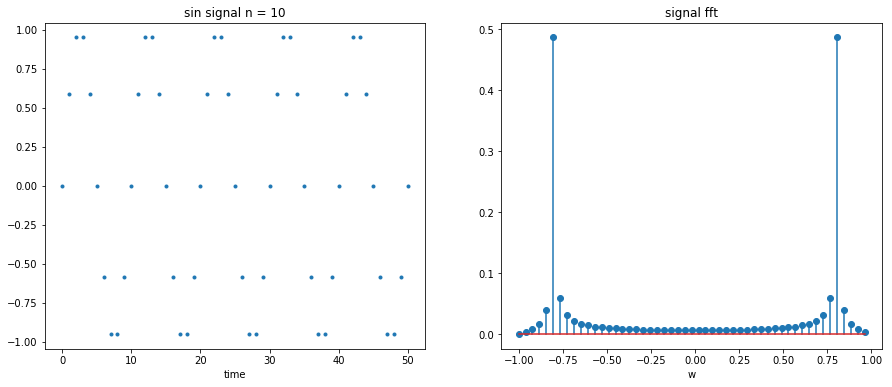

In [18]:
test_func(10)

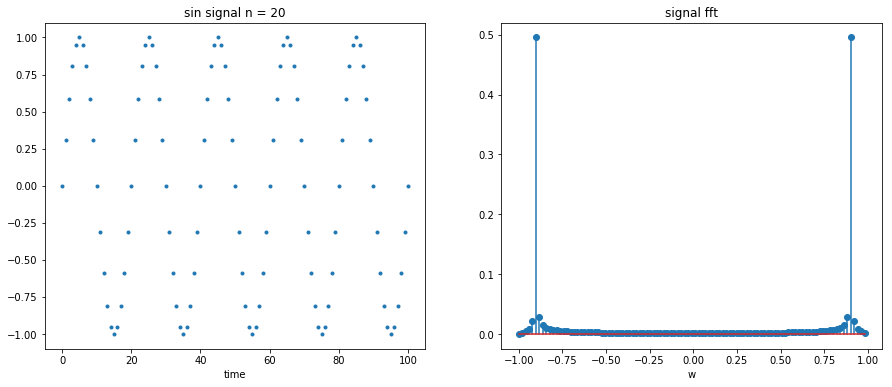

In [19]:
test_func(20)

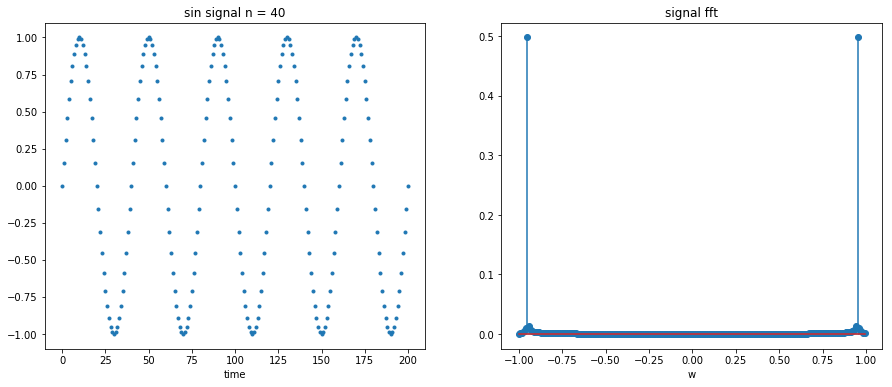

In [20]:
test_func(40)

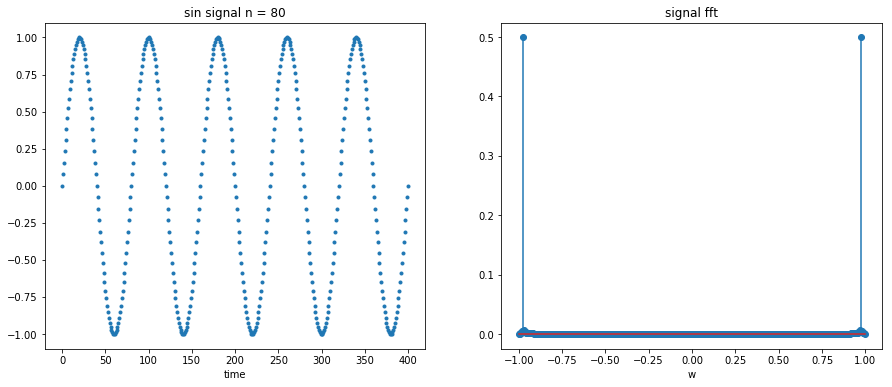

In [21]:
test_func(80)

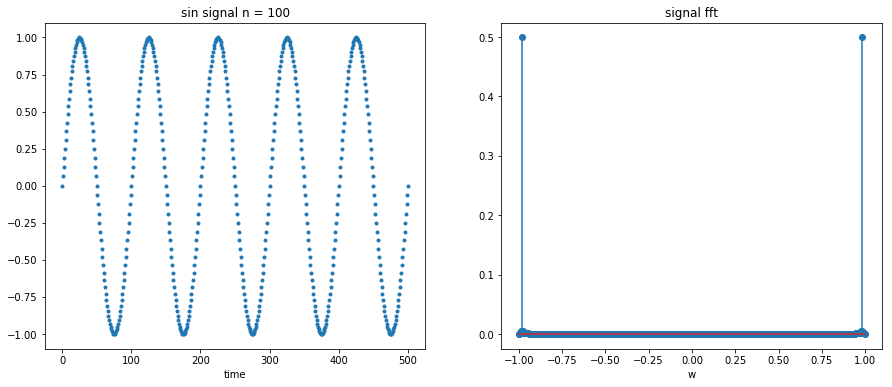

In [22]:
test_func(100)

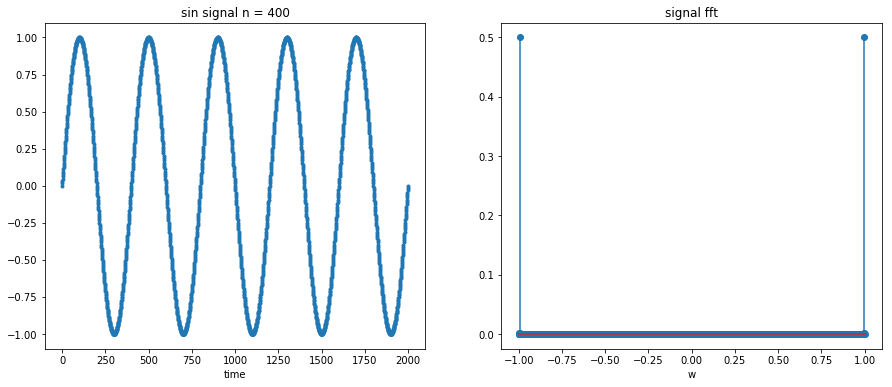

In [23]:
test_func(400)

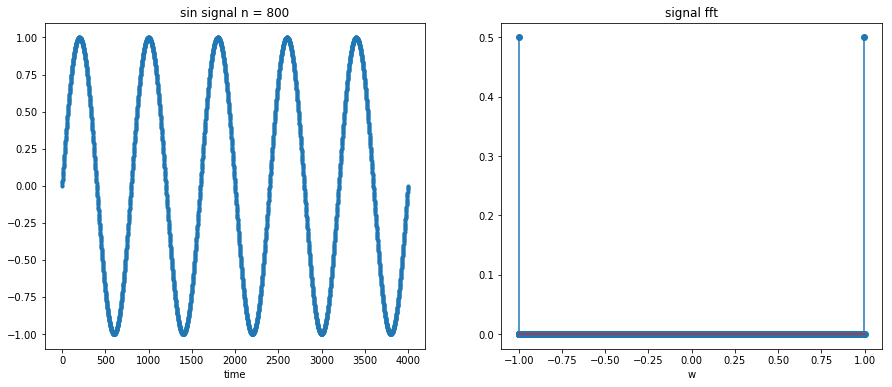

In [24]:
test_func(800)

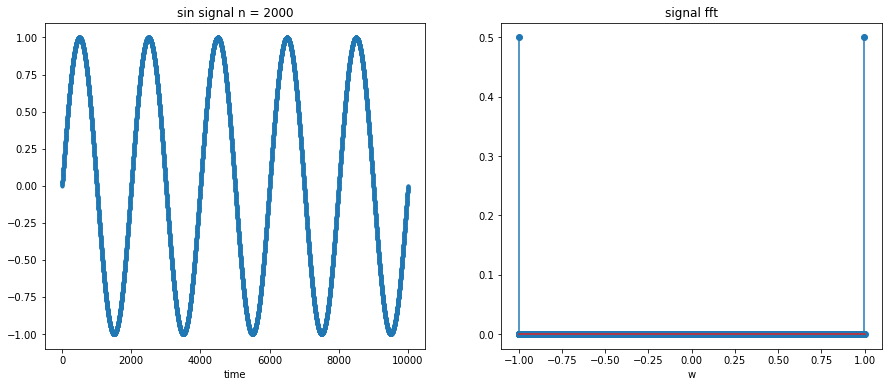

In [25]:
test_func(2000)

### 实验结论
通过上述图示可以看出，当一个周期内取的点数逐渐增多，信号保持产生的台阶越来越少，越来越接近于真实的正弦信号，